In [197]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import deque

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
cars_per_hour = 2000
total_number_cars = 200
n_lanes = 2
average_velocity = 25 * 0.447
intervehicle_spacing = 9.0
position_random_seed = None

In [244]:
average_velocity / intervehicle_spacing * n_lanes

2.4833333333333334

In [245]:
cars_per_second

1.1111111111111112

In [262]:
def poission_positions(cars_per_hour: float,
                       total_number_cars: int,
                       n_lanes: int = 2,
                       average_velocity: float = 25 * 0.447,
                       intervehicle_spacing: float = 9.0,
                       position_random_seed: int = None):
    ''' Simulate a poisson queuing process where vehicles arrive according to a poisson distribution
    and are assigned lanes.  Single arrival queue, n-queue departures.
    Users specifiy a density in terms of cars per hour, number of lanes, and total number of desired cars
    '''
    cars_per_second = cars_per_hour / 3600.0
#     if cars_per_second > (average_velocity / intervehicle_spacing * n_lanes):
#         raise Exception("Car density is too large for given car velocity, number lanes, and inter-vehicle spacing")

    # Spatial resolution should be around 0.5 meters
    spatial_resolution = 0.50 #m
    dt = spatial_resolution / average_velocity
    cars_per_dt = cars_per_second * dt
    total_seconds = total_number_cars * 3600.0 / cars_per_hour * 10
    total_dt = int(total_seconds / dt)

    rng = np.random.default_rng(position_random_seed)
    n_cars_arrival_per_dt = rng.poisson(cars_per_dt, int(total_dt))  # number cars arriving at each dt
    # Exclude arrivals after we have achieved our desired number of vehicles
    n_cars_arrival_per_dt = n_cars_arrival_per_dt[:np.argmax(np.cumsum(n_cars_arrival_per_dt) > total_number_cars)]

    lane_car_positions = {0: [], 1: []}
    lane_ids = list(lane_car_positions.keys())
    road_queue = deque()
    agent_id = 0

    si = 0

    while np.sum([len(lane_car_positions[lane]) for lane in lane_ids]) < total_number_cars:    
        if si >= 2*len(n_cars_arrival_per_dt):
            raise Exception("Too many vehicles in the system ??")

        # Add incoming cars to the system
        if si < len(n_cars_arrival_per_dt) and n_cars_arrival_per_dt[si] > 0:
            # Cars are arriving to the system
            number_cars_arriving = n_cars_arrival_per_dt[si]
            for i in range(number_cars_arriving):
                agent_id += 1
                road_queue.append(agent_id)

        # Attempt to assign arriving cars into lane
        if len(road_queue) > 0:
            rng.shuffle(lane_ids)
            for lane in lane_ids:
                if len(lane_car_positions[lane]) > 0:
                    closest_car = lane_car_positions[lane][0]
                    if closest_car > intervehicle_spacing:
                        car_id = road_queue.popleft()
                        lane_car_positions[lane] = [0.0] + lane_car_positions[lane]
                else:
                    car_id = road_queue.popleft()
                    lane_car_positions[lane] = [0.0] + lane_car_positions[lane]

                if len(road_queue) == 0:
                    break

        # All cars move forward assuming constant velocity and update their position
        for lane in lane_car_positions:
            lane_car_positions[lane] = [pos + dt*average_velocity for pos in lane_car_positions[lane]]
        si += 1

    initial_vehicle_positions = []
    for lane in lane_car_positions:
        initial_vehicle_positions += [(lane, float(x)) for x in lane_car_positions[lane]]

    initial_vehicle_positions = sorted(initial_vehicle_positions, key=lambda l: l[1])    
    
    return initial_vehicle_positions

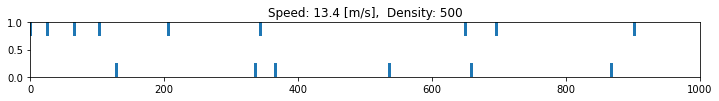

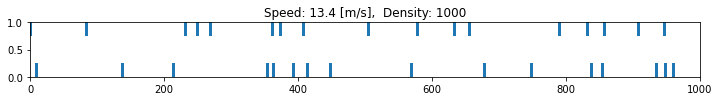

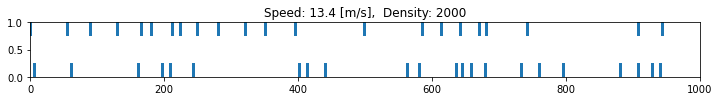

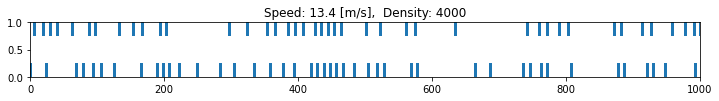

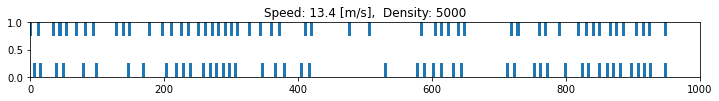

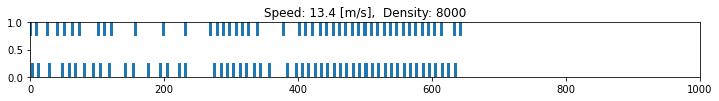

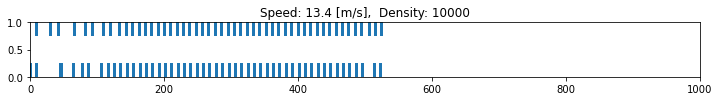

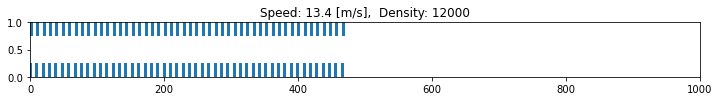

In [267]:
for cars_per_hour in [500, 1000, 2000, 4000, 5000, 8000, 10000, 12000]:
    total_number_cars = 100
    n_lanes = 2
    average_velocity = 30 * 0.447
    intervehicle_spacing = 9.0
    position_random_seed = 0
    
    initial_vehicle_positions = poission_positions(cars_per_hour, total_number_cars, n_lanes, average_velocity, intervehicle_spacing, position_random_seed)
    max_distance = initial_vehicle_positions[-1][1]
        
    length = 4.5
    width = 0.5
#     for i in range(10):
    fig = plt.gcf()
    fig.set_size_inches(12, 1)
    ax = plt.gca()

    for (lane, x) in initial_vehicle_positions:
        rect = patches.Rectangle((x-length/2.0, lane-width/2.0), length, width)
        ax.add_patch(rect)
#     ax.axis('square')
    plt.xlim([0, 1000])
    plt.title("Speed: %0.1f [m/s],  Density: %d"%(average_velocity, cars_per_hour))
    plt.show()

In [259]:
25 / (2*0.002796)*2

8941.34477825465

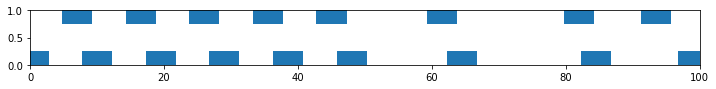

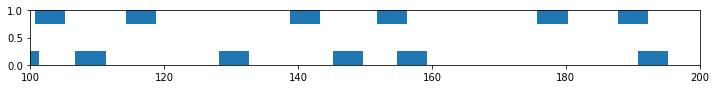

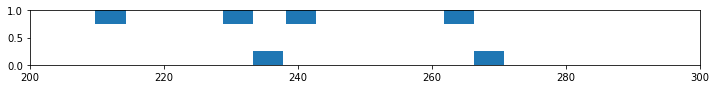

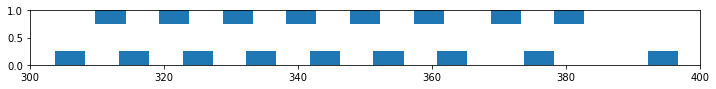

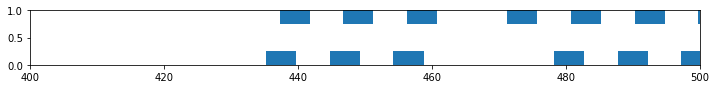

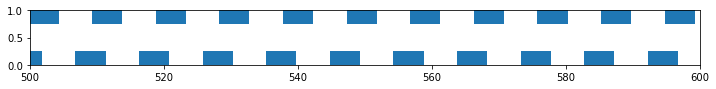

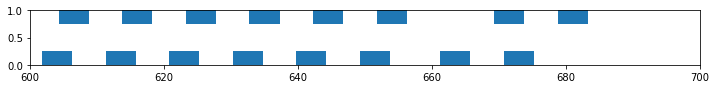

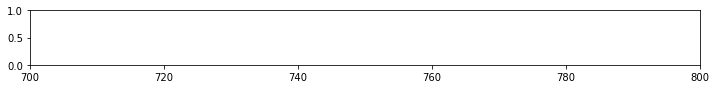

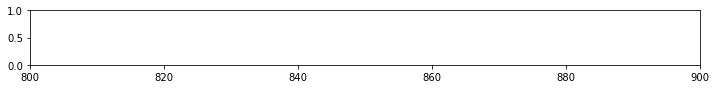

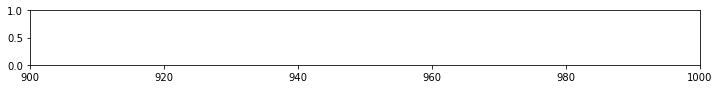

In [257]:
length = 4.5
width = 0.5
for i in range(10):
    fig = plt.gcf()
    fig.set_size_inches(12, 1)
    ax = plt.gca()

    for (lane, x) in initial_vehicle_positions:
        rect = patches.Rectangle((x-length/2.0, lane-width/2.0), length, width)
        ax.add_patch(rect)
#     ax.axis('square')
    plt.xlim([100*i, 100*(i+1)])
    
    plt.show()
    

In [125]:
np.min(np.diff(lane_car_positions[lane]))

11.174999999998363